In [1]:
import gym
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from cryoenv.mqtt import SoftActorCritic, ReturnTracker, HistoryWriter

In [2]:
np.random.seed(2)
# 1, 300 steps --> found after ~ 50 steps, 150 steps --> found after ~ 50 steps
# 2, 300 steps --> ..., 150 steps --> found after ~ 50 steps
# 3, 300 steps --> ..., 150 steps --> ...
# 4, 300 steps --> ..., 150 steps --> ...
# 5
# 6
# 7
# 8

In [3]:
torch.cuda.is_available()

False

In [4]:
warnings.simplefilter('ignore')
gym.logger.set_level(40)

In [5]:
env = gym.make('cryoenv:cryoenv-sig-v0',
                   omega=1e-2,
                   sample_pars=False,
                   pars={'store_raw': False,
                         'max_buffer_len': 1e4,
                         'tpa_queue': [1],
                         'pileup_prob': 0.,
                         'xi': np.array([1e2])},
               render_mode='human',
                   )

In [6]:
obs, info = env.reset()

In [7]:
model = SoftActorCritic(env, policy = "GaussianPolicy", critic = "QNetwork", lr=1e-3, buffer_size=1e4, learning_starts=0,
                        batch_size=16, gamma=.9, gradient_steps=100, 
                        device='cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
tracker = ReturnTracker()
writer = HistoryWriter()

In [9]:
model.learn(episodes = 1, 
            episode_steps = 150, 
            two_pbars=True,
            tracker=tracker,
            writer=writer)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

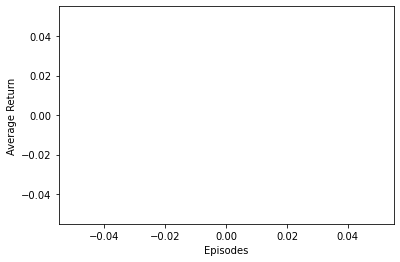

In [10]:
tracker.plot(smooth=1)

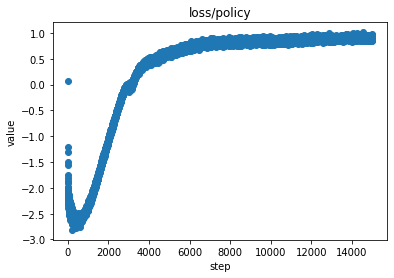

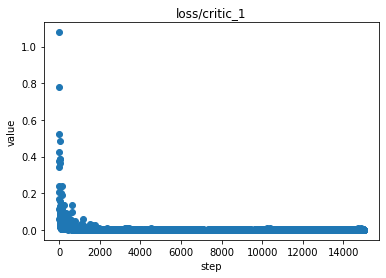

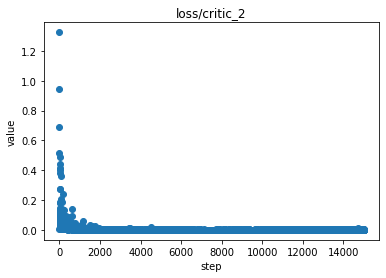

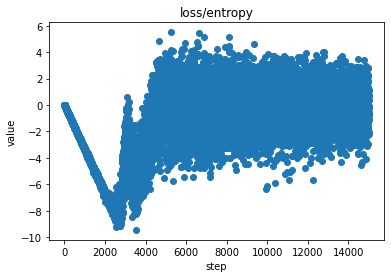

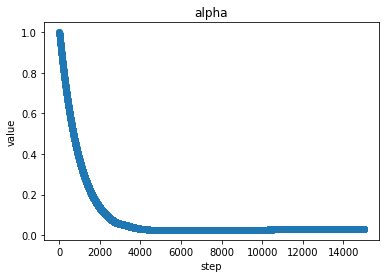

In [11]:
for key in writer.history.keys():
    writer.plot(key)

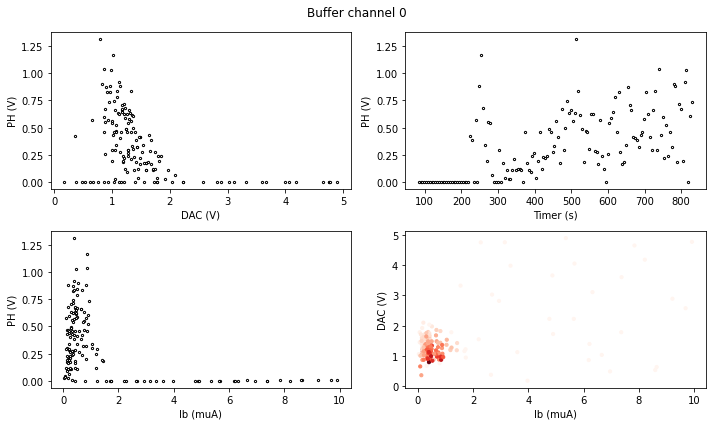

In [12]:
env.detector.plot_buffer()

  0%|          | 0/10 [00:00<?, ?it/s]

[[-0.35093838 -0.9461803 ]]
[-0.98595716 -0.99998785 -0.94618028 -0.35093838] -0.005107109169652474


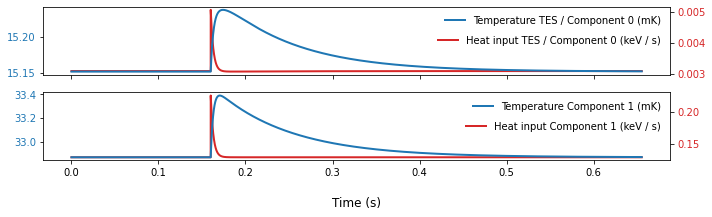

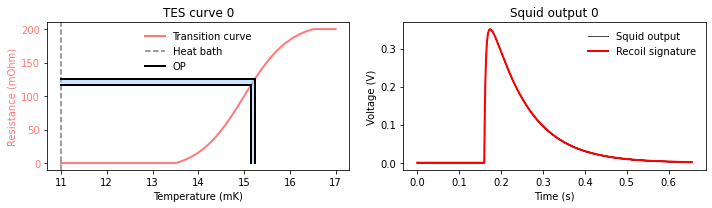

[[-0.51986295 -0.9144001 ]]
[-0.98080526 -0.9999878  -0.9144001  -0.51986295] -0.0009311831784037084


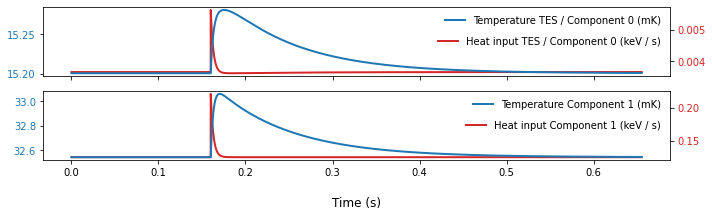

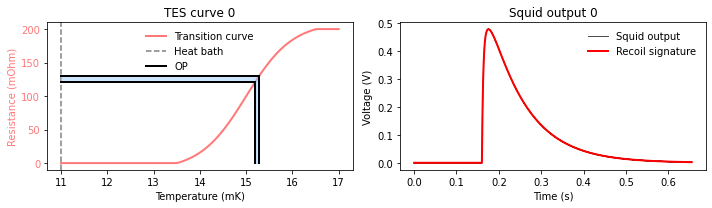

[[-0.49034914 -0.91612893]]
[-0.98040515 -0.99998797 -0.91612893 -0.49034917] -0.0006226610156475564


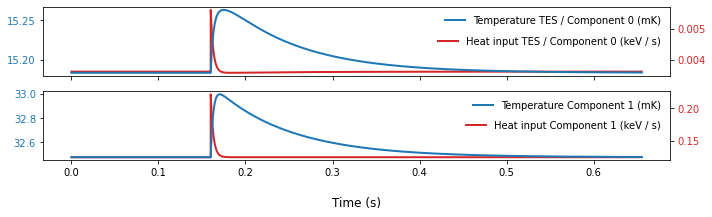

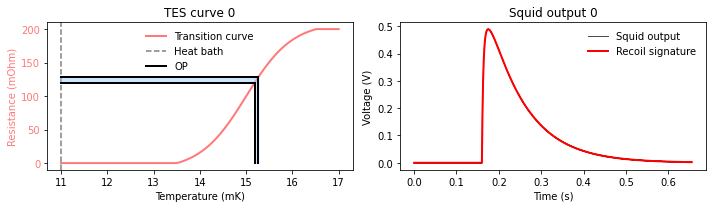

[[-0.49579078 -0.91495186]]
[-0.97998259 -0.99998789 -0.91495186 -0.49579078] -0.0006051329469937588


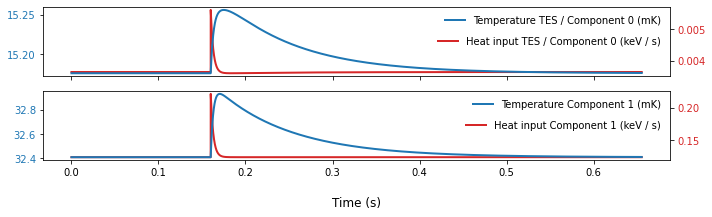

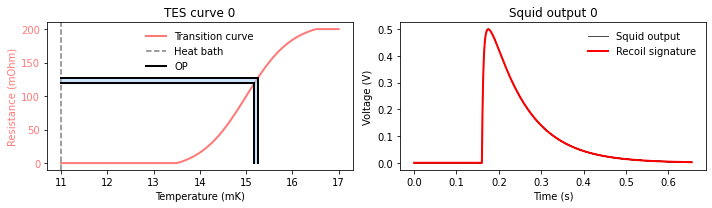

[[-0.4948035  -0.91508245]]
[-0.97980163 -0.99998752 -0.91508245 -0.49480349] -0.0006180419850145513


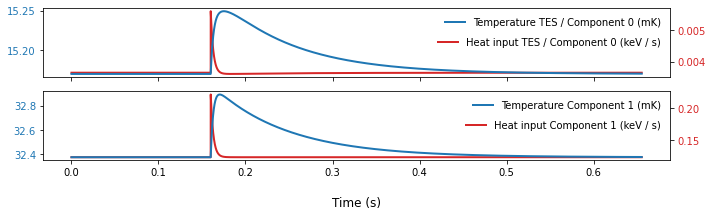

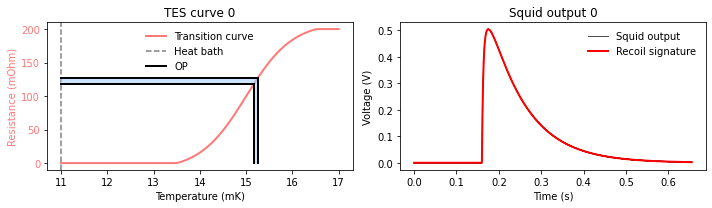

[[-0.4949651 -0.9150387]]
[-0.97969541 -0.99998791 -0.9150387  -0.49496508] -0.0005953254857035234


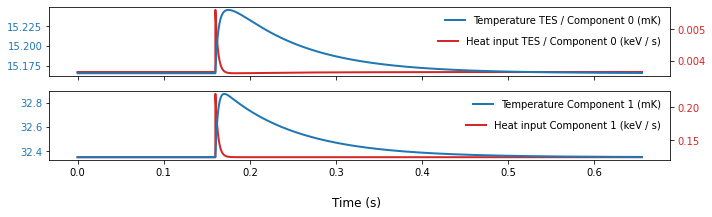

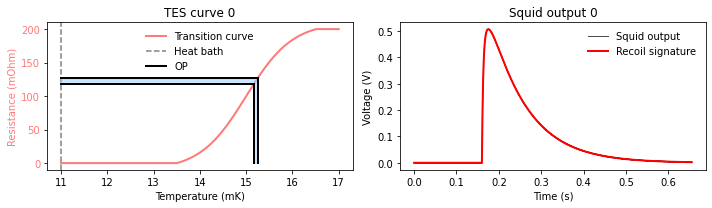

[[-0.49492764 -0.9150367 ]]
[-0.97962374 -0.99998779 -0.91503668 -0.49492764] -0.0005993654024948938


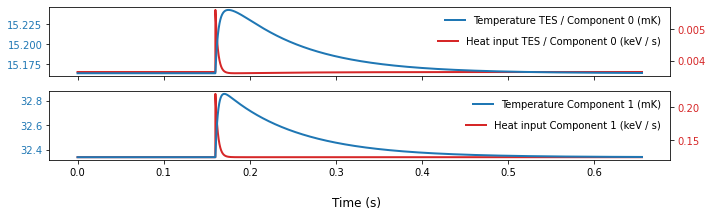

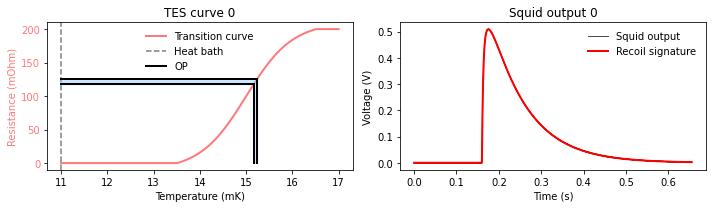

[[-0.49492818 -0.9150308 ]]
[-0.9795876  -0.99998782 -0.91503078 -0.49492818] -0.0005966176597920052


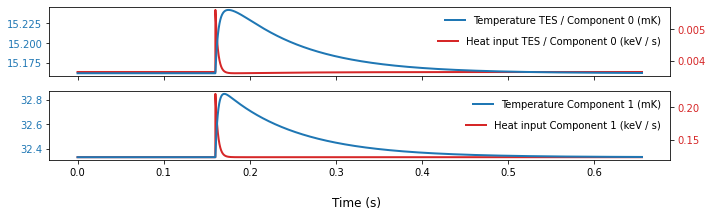

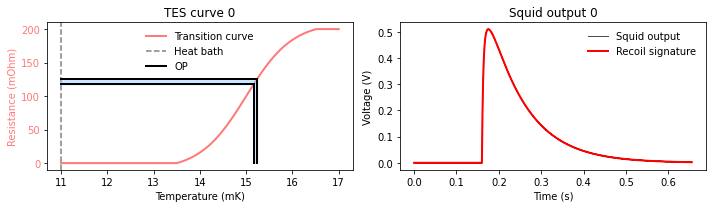

[[-0.49492514 -0.91502833]]
[-0.97956447 -0.99998793 -0.91502833 -0.49492514] -0.0005905619573992666


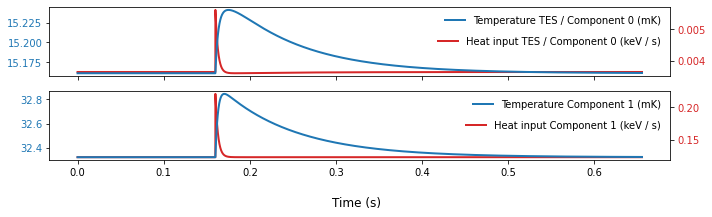

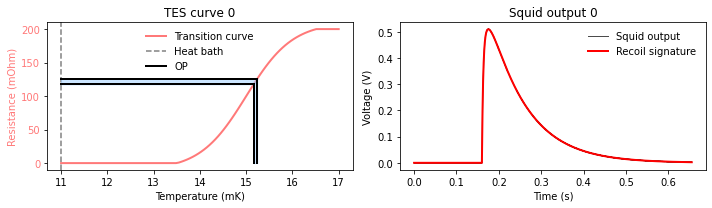

[[-0.49492374 -0.9150267 ]]
[-0.97955059 -0.99998756 -0.91502672 -0.49492371] -0.0006085547670772955


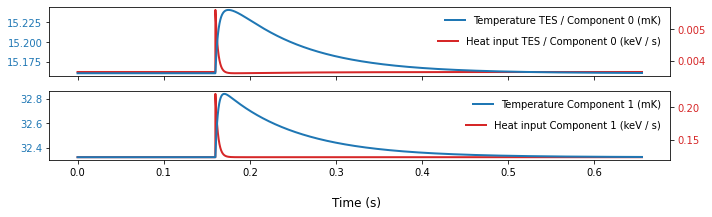

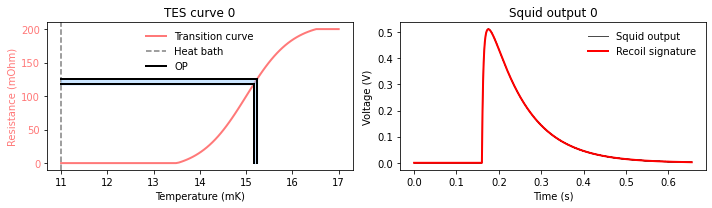

In [13]:
obs, _ = env.reset()
model.policy.eval()
returns = 0
for i in trange(10):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action.flatten())
    print(action)
    print(obs, reward)
    returns += reward
    env.render()
    if terminated or truncated:
        obs, _ = env.reset()

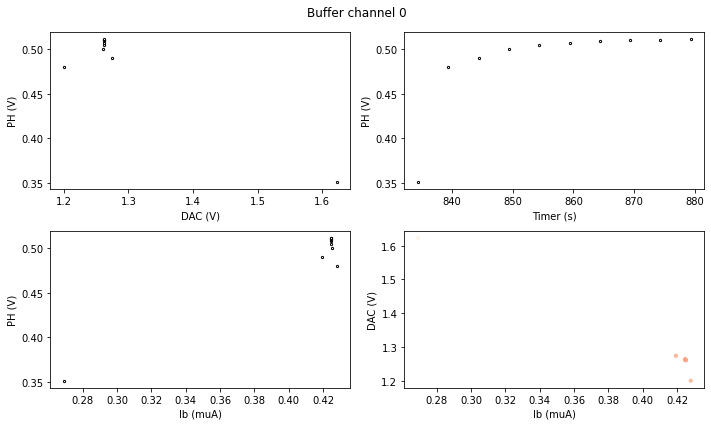

In [14]:
env.detector.plot_buffer()

In [ ]:
env.close()

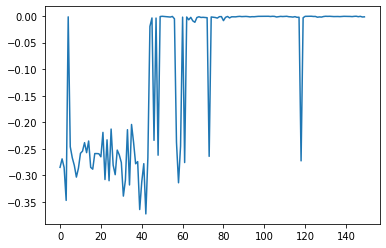

In [16]:
plt.plot(model.buffer.reward_memory[:150])